# Лабораторная работа 1: Классификация изображений

## Import libs

In [3]:
import einops
from tqdm.notebook import tqdm

from torchsummary import summary

import time

import pandas as pd
import torch
from torch import nn
import torchvision
import torch.optim as optim
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomHorizontalFlip, RandomCrop


## Get data

In [4]:
import os


In [5]:
cars_annos_train_df = pd.read_csv('cars_annos_train.csv')
cars_annos_test_df = pd.read_csv('cars_annos_test.csv')

cars_annos_train_df


,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname
0,39,116,569,375,14,00001.jpg
1,36,116,868,587,3,00002.jpg
2,85,109,601,381,91,00003.jpg
3,621,393,1484,1096,134,00004.jpg
4,14,36,133,99,106,00005.jpg
...,...,...,...,...,...,...
8139,3,44,423,336,78,08140.jpg
8140,138,150,706,523,196,08141.jpg
8141,26,246,660,449,163,08142.jpg
8142,78,526,1489,908,112,08143.jpg


In [36]:
class_counts = cars_annos_train_df['class'].value_counts()
class_counts


class
147    31
119    30
20     30
146    29
193    29
       ..
33     13
67     13
64     12
163    11
136     9
Name: count, Length: 196, dtype: int64

In [37]:
cars_annos_train_df = cars_annos_train_df.sample(2000, random_state=42).reset_index(drop=True)
cars_annos_test_df = cars_annos_test_df.sample(2000, random_state=42).reset_index(drop=True)


In [38]:
cars_annos_train_df['class'] = cars_annos_train_df['class'].astype('category')
cars_annos_test_df['class'] = cars_annos_test_df['class'].astype('category')


## Train test split

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms.functional import crop
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


In [40]:
def plot_batch(images: torch.Tensor, labels: torch.Tensor):
    num_images = images.size(0)
    num_rows = int(np.ceil(np.sqrt(num_images)))

    fig, axs = plt.subplots(num_rows, num_rows)
    fig.subplots_adjust(hspace=0.1, wspace=1)

    for i, ax in enumerate(axs.flatten()):
        if i < num_images:
            image, label = images[i], str(int(labels[i]))
            image = image.numpy().transpose((1, 2, 0))
            image = (image * 0.5) + 0.5

            ax.imshow(image.squeeze())
            ax.set_title(int(label), fontsize=12)
            ax.axis("off")
        else:
            ax.axis("off")

    plt.show()
    

In [41]:
class ImageDataset(Dataset):
    def __init__(self, image_dataframe, image_dir, transform=None):
        self.image_dataframe = image_dataframe
        self.transform = transform
        self.image_dataframe['im_path'] = self.image_dataframe['fname'].apply(lambda x: os.path.join(image_dir, x))

    def __len__(self):
        return len(self.image_dataframe)

    def __getitem__(self, idx):
        image_path = self.image_dataframe.loc[idx, 'im_path']
        label = self.image_dataframe.loc[idx, 'class']
            
        image = Image.open(image_path)

        if image.mode == 'L':
            image = image.convert('RGB')

        # Get bounding box coordinates
        bbox_x1 = self.image_dataframe.loc[idx, 'bbox_x1']
        bbox_y1 = self.image_dataframe.loc[idx, 'bbox_y1']
        bbox_x2 = self.image_dataframe.loc[idx, 'bbox_x2']
        bbox_y2 = self.image_dataframe.loc[idx, 'bbox_y2']

        # Crop the image using bounding box coordinates
        image = crop(image, top=bbox_y1, left=bbox_x1, height=bbox_y2-bbox_y1, width=bbox_x2-bbox_x1)

        if self.transform:
            image = self.transform(image)

        return image, label


In [42]:
torch.manual_seed(42)

# transform = transforms.Compose([
#   transforms.Resize((224, 224)),
#   transforms.ToTensor(),
#   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
# ])

transform = transforms.Compose([
    # transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_set = ImageDataset(cars_annos_train_df, 'cars_train', transform=transform)
test_set = ImageDataset(cars_annos_test_df, 'cars_test', transform=transform)


In [43]:
batch_size = 4

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


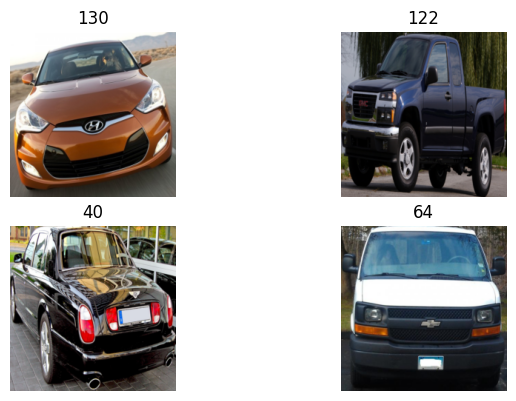

In [44]:
batch_images, batch_labels = next(iter(train_loader))
plot_batch(batch_images, batch_labels)


## ViT


In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [46]:
patch_size = 16         # Patch size (P) = 16
latent_size = 768       # Latent vector (D). ViT-Base uses 768
n_channels = 3          # Number of channels for input images
num_heads = 12          # ViT-Base uses 12 heads
num_encoders = 12       # ViT-Base uses 12 encoder layers
dropout = 0.1           # Dropout = 0.1 is used with ViT-Base & ImageNet-21k
num_classes = 197       # Number of classes in the dataset
size = 224              # Size used for training = 224

epochs = 30             # Number of epochs
base_lr = 10e-3         # Base LR
weight_decay = 0.03     # Weight decay for ViT-Base (on ImageNet-21k)


In [47]:
epochs = 10

In [48]:
class InputEmbedding(nn.Module):
    def __init__(self, patch_size=patch_size, n_channels=n_channels, device=device, latent_size=latent_size, batch_size=batch_size):
        super(InputEmbedding, self).__init__()
        self.latent_size = latent_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.device = device
        self.batch_size = batch_size
        self.input_size = self.patch_size * self.patch_size * self.n_channels

        self.linearProjection = nn.Linear(self.input_size, self.latent_size)

        # Random initialization of of [class] token that is prepended to the linear projection vector.
        self.class_token = nn.Parameter(torch.randn(self.batch_size, 1, self.latent_size)).to(self.device)

        # Positional embedding
        self.pos_embedding = nn.Parameter(torch.randn(self.batch_size, 1, self.latent_size)).to(self.device)


    def forward(self, input_data):

        input_data = input_data.to(self.device)

        # Re-arrange image into patches.
        patches = einops.rearrange(
            input_data, 'b c (h h1) (w w1) -> b (h w) (h1 w1 c)', h1=self.patch_size, w1=self.patch_size)

        linear_projection = self.linearProjection(patches).to(self.device)
        b, n, _ = linear_projection.shape

        # Prepend the [class] token to the original linear projection
        linear_projection = torch.cat((self.class_token, linear_projection), dim=1)
        pos_embed = einops.repeat(self.pos_embedding, 'b 1 d -> b m d', m=n+1)

        # Add positional embedding to linear projection
        linear_projection += pos_embed

        return linear_projection
        

In [49]:
class EncoderBlock(nn.Module):
    def __init__(self, latent_size=latent_size, num_heads=num_heads, device=device, dropout=dropout):
        super(EncoderBlock, self).__init__()

        self.latent_size = latent_size
        self.num_heads = num_heads
        self.device = device
        self.dropout = dropout

        # Normalization layer for both sublayers
        self.norm = nn.LayerNorm(self.latent_size)
        
        # Multi-Head Attention layer
        self.multihead = nn.MultiheadAttention(
            self.latent_size, self.num_heads, dropout=self.dropout)          

        # MLP_head layer in the encoder. I use the same configuration as that 
        # used in the original VitTransformer implementation. The ViT-Base
        # variant uses MLP_head size 3072, which is latent_size*4.
        self.enc_MLP = nn.Sequential(
            nn.Linear(self.latent_size, self.latent_size*4),
            nn.GELU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.latent_size*4, self.latent_size),
            nn.Dropout(self.dropout)
        )

    def forward(self, embedded_patches):

        # First sublayer: Norm + Multi-Head Attention + residual connection.
        # We take the first element ([0]) of the returned output from nn.MultiheadAttention()
        # because this module returns 'Tuple[attention_output, attention_output_weights]'. 
        # Refer to here for more info: https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html 
        firstNorm_out = self.norm(embedded_patches)
        attention_output = self.multihead(firstNorm_out, firstNorm_out, firstNorm_out)[0]

        # First residual connection
        first_added_output = attention_output + embedded_patches

        # Second sublayer: Norm + enc_MLP (Feed forward)
        secondNorm_out = self.norm(first_added_output)
        ff_output = self.enc_MLP(secondNorm_out)

        # Return the output of the second residual connection
        return ff_output + first_added_output
        

In [50]:
class VitTransformer(nn.Module):
    def __init__(self, num_encoders=num_encoders, latent_size=latent_size, device=device, num_classes=num_classes, dropout=dropout):
        super(VitTransformer, self).__init__()
        self.num_encoders = num_encoders
        self.latent_size = latent_size
        self.device = device
        self.num_classes = num_classes
        self.dropout = dropout

        self.embedding = InputEmbedding()

        # Create a stack of encoder layers
        self.encStack = nn.ModuleList([EncoderBlock() for i in range(self.num_encoders)])

        # MLP_head at the classification stage has 'one hidden layer at pre-training time
        # and by a single linear layer at fine-tuning time'. For this implementation I will
        # use what was used for training, so I'll have a total of two layers, one hidden
        # layer and one output layer.
        self.MLP_head = nn.Sequential(
            nn.LayerNorm(self.latent_size),
            nn.Linear(self.latent_size, self.latent_size),
            nn.Linear(self.latent_size, self.num_classes)
        )

    def forward(self, test_input):

        # Apply input embedding (patchify + linear projection + position embeding)
        # to the input image passed to the model
        enc_output = self.embedding(test_input)

        # Loop through all the encoder layers
        for enc_layer in self.encStack:
            enc_output = enc_layer.forward(enc_output)

        # Extract the output embedding information of the [class] token
        cls_token_embedding = enc_output[:, 0]

        # Finally, return the classification vector for all image in the batch
        return self.MLP_head(cls_token_embedding)
        

In [51]:
model = VitTransformer(num_encoders, latent_size, device, num_classes).to(device)

# Betas used for Adam in paper are 0.9 and 0.999, which are the default in PyTorch
# optimizer = optim.Adam(model.parameters(), lr=base_lr, weight_decay=weight_decay)
# criterion = nn.CrossEntropyLoss()
# scheduler = optim.lr_scheduler.LinearLR(optimizer)


In [52]:
import torch
import torch.nn as nn
import torch.optim as optim

class AdaBound(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3, weight_decay=0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, weight_decay=weight_decay)
        super(AdaBound, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # Update exponential moving averages
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                # Compute the bounds
                lower_bound = group['lr'] * (1.0 - 1.0 / (group['gamma'] * state['step'] + 1))
                upper_bound = group['lr'] * (1.0 + 1.0 / (group['gamma'] * state['step']))

                # Clamp the learning rate
                lr = min(max(lower_bound, group['lr']), upper_bound)

                # Perform the parameter update
                p.data.addcdiv_(-lr, exp_avg, torch.sqrt(exp_avg_sq) + group['weight_decay'] * p.data)

        return loss
        

## Training

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import f1_score

def fine_tune(name, model, train_data_loader, valid_data_loader, writer, start_epoch=0, epochs=10, device='cuda', optimizer='adabound', learning_rate=0.001):
    min_loss = np.inf
    
    if optimizer == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer == 'adabound':
        optimizer = AdaBound(model.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer}")

    model.to(device)
    model.train()
    
    for ep in range(epochs):
        running_loss = 0.0
        train_predictions = []
        train_labels = []

        epoch = ep + start_epoch

        for inputs, labels in tqdm(train_data_loader, desc=f"Epoch {epoch+1}/{start_epoch + epochs}"):
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            loss = nn.CrossEntropyLoss()(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            train_predictions.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        loss = running_loss / len(train_data_loader.dataset)
        
        valid_loss, f1, accuracy = calculate_metrics(model, valid_data_loader, device)

        if valid_loss < min_loss:
            print('Saving model...')
            min_loss = valid_loss

            torch.save(model.state_dict(), f'./checkpoints/{name}_{epoch}_{int(valid_loss)}.pt')

        writer.add_scalar("Training Loss", loss, epoch)
        writer.add_scalar("Validation Loss", valid_loss, epoch)
        writer.add_scalar("Validation F1 Score", f1, epoch)
        writer.add_scalar("Validation Accuracy", accuracy, epoch)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss}, Validation loss: {valid_loss}, Min loss: {min_loss}, F1 Score: {f1}, Accuracy: {accuracy}')
    
    return model

def calculate_metrics(model, data_loader, device='cuda'):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    predictions = []
    labels = []
    total_loss = 0.0
    # f1 = f1_score(num_classes=num_classes)  # Replace 'your_num_classes' with the actual number of classes

    with torch.no_grad():
        for inputs, batch_labels in tqdm(data_loader):
            inputs, batch_labels = inputs.to(device), batch_labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, batch_labels)
            
            total_loss += loss.item()
            predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    model.train()
    
    predictions = torch.tensor(predictions)
    labels = torch.tensor(labels)

    f1 = f1_score(predictions, labels, average='macro')
    accuracy = torch.sum(predictions == labels).item() / len(labels)

    return total_loss, f1, accuracy


In [56]:
from torch.utils.tensorboard import SummaryWriter

def fine_tune_model_with_writer(name, model, start_epoch=0, epochs=10, device='cuda', optimizer='adabound', learning_rate=0.001):
    writer = SummaryWriter(name)
    model = model.to(device)
    model = fine_tune(name, model, train_loader, test_loader, writer, start_epoch, epochs, device, optimizer, learning_rate)
    writer.flush()

    return model
    

### Adabound

In [61]:
model_custom_vit_adabound = VitTransformer(num_encoders, latent_size, device, num_classes).to(device)
fine_tune_model_with_writer("custom_vit_adabound", model_custom_vit_adabound, epochs=42, optimizer='adabound')


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:25<00:00, 19.36it/s]


Saving model...
Epoch 1/42, Loss: 5.909276173591614, Validation loss: 2880.098961830139, Min loss: 2880.098961830139, F1 Score: 4.065371168387674e-05, Accuracy: 0.004


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:26<00:00, 19.03it/s]


Saving model...
Epoch 2/42, Loss: 5.439171188354492, Validation loss: 2688.0297527313232, Min loss: 2688.0297527313232, F1 Score: 3.052068284941095e-05, Accuracy: 0.003


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:26<00:00, 19.01it/s]


Saving model...
Epoch 3/42, Loss: 5.302112481117248, Validation loss: 2651.99937582016, Min loss: 2651.99937582016, F1 Score: 5.58154639279879e-05, Accuracy: 0.0055


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:25<00:00, 19.30it/s]


Saving model...
Epoch 4/42, Loss: 5.275788950920105, Validation loss: 2646.7427549362183, Min loss: 2646.7427549362183, F1 Score: 7.343824248223099e-05, Accuracy: 0.0035


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:25<00:00, 19.66it/s]


Epoch 5/42, Loss: 5.270287240028382, Validation loss: 2654.576156139374, Min loss: 2646.7427549362183, F1 Score: 4.571266037525015e-05, Accuracy: 0.0045


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:25<00:00, 19.71it/s]


Epoch 6/42, Loss: 5.264158421516418, Validation loss: 2650.579120159149, Min loss: 2646.7427549362183, F1 Score: 0.00012123661345726409, Accuracy: 0.006


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:25<00:00, 19.35it/s]


Epoch 7/42, Loss: 5.266866542816162, Validation loss: 2647.7628774642944, Min loss: 2646.7427549362183, F1 Score: 4.065371168387674e-05, Accuracy: 0.004


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:25<00:00, 19.32it/s]


Epoch 8/42, Loss: 5.264205783843994, Validation loss: 2660.148729801178, Min loss: 2646.7427549362183, F1 Score: 4.571266037525015e-05, Accuracy: 0.0045


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:25<00:00, 19.49it/s]


Epoch 9/42, Loss: 5.2646510124206545, Validation loss: 2649.785886287689, Min loss: 2646.7427549362183, F1 Score: 4.065371168387674e-05, Accuracy: 0.004


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:25<00:00, 19.36it/s]


Epoch 10/42, Loss: 5.265734882354736, Validation loss: 2651.9002199172974, Min loss: 2646.7427549362183, F1 Score: 4.733503739467954e-05, Accuracy: 0.0035


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:24<00:00, 20.22it/s]


Epoch 11/42, Loss: 5.263744033813476, Validation loss: 2653.1162915229797, Min loss: 2646.7427549362183, F1 Score: 0.00016056034034913217, Accuracy: 0.008


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:25<00:00, 19.99it/s]


Epoch 12/42, Loss: 5.265470935821533, Validation loss: 2652.7632298469543, Min loss: 2646.7427549362183, F1 Score: 5.076657528683116e-05, Accuracy: 0.005


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:24<00:00, 20.51it/s]


Epoch 13/42, Loss: 5.264869437217713, Validation loss: 2658.382553577423, Min loss: 2646.7427549362183, F1 Score: 5.076657528683116e-05, Accuracy: 0.005


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:24<00:00, 20.07it/s]


Epoch 14/42, Loss: 5.263840545654297, Validation loss: 2668.0515995025635, Min loss: 2646.7427549362183, F1 Score: 0.00010602954690040293, Accuracy: 0.0105


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:24<00:00, 20.07it/s]


Epoch 15/42, Loss: 5.266244863510132, Validation loss: 2653.8213925361633, Min loss: 2646.7427549362183, F1 Score: 7.5960905453993e-05, Accuracy: 0.0075


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:24<00:00, 20.02it/s]


Epoch 16/42, Loss: 5.266288453102112, Validation loss: 2661.675651550293, Min loss: 2646.7427549362183, F1 Score: 4.065371168387674e-05, Accuracy: 0.004


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:24<00:00, 20.25it/s]


Epoch 17/42, Loss: 5.265206086158752, Validation loss: 2668.331865787506, Min loss: 2646.7427549362183, F1 Score: 7.5960905453993e-05, Accuracy: 0.0075


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:25<00:00, 19.86it/s]


Epoch 18/42, Loss: 5.260724196434021, Validation loss: 2668.518389225006, Min loss: 2646.7427549362183, F1 Score: 4.571266037525015e-05, Accuracy: 0.0045


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:25<00:00, 19.90it/s]


Epoch 19/42, Loss: 5.2637417640686035, Validation loss: 2659.426664829254, Min loss: 2646.7427549362183, F1 Score: 0.00012715451742444165, Accuracy: 0.0085


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 16.79it/s]


Epoch 20/42, Loss: 5.265643187522889, Validation loss: 2659.50000667572, Min loss: 2646.7427549362183, F1 Score: 7.5960905453993e-05, Accuracy: 0.0075


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 17.03it/s]


Epoch 21/42, Loss: 5.26427663230896, Validation loss: 2653.052426338196, Min loss: 2646.7427549362183, F1 Score: 4.571266037525015e-05, Accuracy: 0.0045


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 17.15it/s]


Epoch 22/42, Loss: 5.2670370988845825, Validation loss: 2659.5789704322815, Min loss: 2646.7427549362183, F1 Score: 5.58154639279879e-05, Accuracy: 0.0055


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 17.14it/s]


Epoch 23/42, Loss: 5.2626408748626705, Validation loss: 2661.543269634247, Min loss: 2646.7427549362183, F1 Score: 2.5446587612601155e-05, Accuracy: 0.0025


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.32it/s]


Epoch 24/42, Loss: 5.260377449989319, Validation loss: 2673.4760389328003, Min loss: 2646.7427549362183, F1 Score: 8.107542946105238e-05, Accuracy: 0.004


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.58it/s]


Epoch 25/42, Loss: 5.263528100967407, Validation loss: 2668.068796157837, Min loss: 2646.7427549362183, F1 Score: 0.0001453257043793411, Accuracy: 0.006


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.35it/s]


Epoch 26/42, Loss: 5.265404742240905, Validation loss: 2668.5666880607605, Min loss: 2646.7427549362183, F1 Score: 7.5960905453993e-05, Accuracy: 0.0075


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 16.77it/s]


Epoch 27/42, Loss: 5.266378722190857, Validation loss: 2667.201560497284, Min loss: 2646.7427549362183, F1 Score: 4.571266037525015e-05, Accuracy: 0.0045


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:30<00:00, 16.58it/s]


Epoch 28/42, Loss: 5.263775690078735, Validation loss: 2663.619854927063, Min loss: 2646.7427549362183, F1 Score: 7.5960905453993e-05, Accuracy: 0.0075


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.27it/s]


Epoch 29/42, Loss: 5.261575777053833, Validation loss: 2664.8789710998535, Min loss: 2646.7427549362183, F1 Score: 5.076657528683116e-05, Accuracy: 0.005


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 17.20it/s]


Epoch 30/42, Loss: 5.266384140014648, Validation loss: 2674.908661365509, Min loss: 2646.7427549362183, F1 Score: 0.000134372680582366, Accuracy: 0.006


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 17.13it/s]


Epoch 31/42, Loss: 5.262342454910279, Validation loss: 2652.890989303589, Min loss: 2646.7427549362183, F1 Score: 7.5960905453993e-05, Accuracy: 0.0075


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.25it/s]


Epoch 32/42, Loss: 5.2632615242004395, Validation loss: 2658.6350922584534, Min loss: 2646.7427549362183, F1 Score: 4.065371168387674e-05, Accuracy: 0.004


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.30it/s]


Epoch 33/42, Loss: 5.263329956054688, Validation loss: 2675.613133430481, Min loss: 2646.7427549362183, F1 Score: 7.5960905453993e-05, Accuracy: 0.0075


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:35<00:00, 14.03it/s]


Epoch 34/42, Loss: 5.263445608139038, Validation loss: 2657.528754234314, Min loss: 2646.7427549362183, F1 Score: 0.0001603798860700203, Accuracy: 0.008


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.53it/s]


Epoch 35/42, Loss: 5.2588711318969725, Validation loss: 2667.854359149933, Min loss: 2646.7427549362183, F1 Score: 4.571266037525015e-05, Accuracy: 0.0045


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.25it/s]


Epoch 36/42, Loss: 5.2601221723556515, Validation loss: 2671.183853149414, Min loss: 2646.7427549362183, F1 Score: 4.571266037525015e-05, Accuracy: 0.0045


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.26it/s]


Epoch 37/42, Loss: 5.257732374191284, Validation loss: 2671.3934597969055, Min loss: 2646.7427549362183, F1 Score: 4.571266037525015e-05, Accuracy: 0.0045


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.54it/s]


Epoch 38/42, Loss: 5.261939499855042, Validation loss: 2661.6607093811035, Min loss: 2646.7427549362183, F1 Score: 7.5960905453993e-05, Accuracy: 0.0075


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.48it/s]


Epoch 39/42, Loss: 5.261767372131348, Validation loss: 2671.1857771873474, Min loss: 2646.7427549362183, F1 Score: 7.5960905453993e-05, Accuracy: 0.0075


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.34it/s]


Epoch 40/42, Loss: 5.262199352264404, Validation loss: 2664.5704221725464, Min loss: 2646.7427549362183, F1 Score: 7.5960905453993e-05, Accuracy: 0.0075


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 17.14it/s]


Epoch 41/42, Loss: 5.266164926528931, Validation loss: 2665.828278541565, Min loss: 2646.7427549362183, F1 Score: 0.0001305691878838946, Accuracy: 0.0045


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.30it/s]

Epoch 42/42, Loss: 5.255730401992798, Validation loss: 2669.0720915794373, Min loss: 2646.7427549362183, F1 Score: 5.58154639279879e-05, Accuracy: 0.0055


VitTransformer(
  (embedding): InputEmbedding(
    (linearProjection): Linear(in_features=768, out_features=768, bias=True)
  )
  (encStack): ModuleList(
    (0-11): 12 x EncoderBlock(
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (multihead): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (enc_MLP): Sequential(
        (0): Linear(in_features=768, out_features=3072, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=3072, out_features=768, bias=True)
        (4): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (MLP_head): Sequential(
    (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=768, out_features=768, bias=True)
    (2): Linear(in_features=768, out_features=197, bias=True)
  )
)

### Adam

In [62]:
model_custom_vit_adam = VitTransformer(num_encoders, latent_size, device, num_classes).to(device)
fine_tune_model_with_writer("custom_vit_adam", model_custom_vit_adam, epochs=42, optimizer='adam')


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:47<00:00, 10.60it/s]


Saving model...
Epoch 1/42, Loss: 5.786266067504883, Validation loss: 2729.697153568268, Min loss: 2729.697153568268, F1 Score: 4.571266037525015e-05, Accuracy: 0.0045


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:47<00:00, 10.51it/s]


Epoch 2/42, Loss: 5.407418145179749, Validation loss: 2770.3590846061707, Min loss: 2729.697153568268, F1 Score: 3.558972168837639e-05, Accuracy: 0.0035


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:47<00:00, 10.59it/s]


Saving model...
Epoch 3/42, Loss: 5.353307537078857, Validation loss: 2674.464207649231, Min loss: 2674.464207649231, F1 Score: 5.076657528683116e-05, Accuracy: 0.005


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:47<00:00, 10.60it/s]


Saving model...
Epoch 4/42, Loss: 5.324414429664611, Validation loss: 2658.168092727661, Min loss: 2658.168092727661, F1 Score: 7.5960905453993e-05, Accuracy: 0.0075


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:47<00:00, 10.60it/s]


Saving model...
Epoch 5/42, Loss: 5.312013577461243, Validation loss: 2652.2158069610596, Min loss: 2652.2158069610596, F1 Score: 5.076657528683116e-05, Accuracy: 0.005


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:47<00:00, 10.61it/s]


Epoch 6/42, Loss: 5.2975298051834105, Validation loss: 2692.323447227478, Min loss: 2652.2158069610596, F1 Score: 5.076657528683116e-05, Accuracy: 0.005


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:47<00:00, 10.57it/s]


Epoch 7/42, Loss: 5.299161385536194, Validation loss: 2660.574882507324, Min loss: 2652.2158069610596, F1 Score: 9.078765506507548e-05, Accuracy: 0.0045


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 11.92it/s]


Epoch 8/42, Loss: 5.287059776306152, Validation loss: 2693.50341463089, Min loss: 2652.2158069610596, F1 Score: 5.076657528683116e-05, Accuracy: 0.005


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 11.91it/s]


Epoch 9/42, Loss: 5.295778998374939, Validation loss: 2660.917106151581, Min loss: 2652.2158069610596, F1 Score: 6.58981923618926e-05, Accuracy: 0.0065


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 11.91it/s]


Epoch 10/42, Loss: 5.282791544914246, Validation loss: 2682.2319321632385, Min loss: 2652.2158069610596, F1 Score: 4.571266037525015e-05, Accuracy: 0.0045


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:42<00:00, 11.90it/s]


Epoch 11/42, Loss: 5.283723165512085, Validation loss: 2660.2844371795654, Min loss: 2652.2158069610596, F1 Score: 0.00016113177619159322, Accuracy: 0.008


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 11.93it/s]


Epoch 12/42, Loss: 5.282400785446167, Validation loss: 2669.2404594421387, Min loss: 2652.2158069610596, F1 Score: 6.58981923618926e-05, Accuracy: 0.0065


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 11.92it/s]


Epoch 13/42, Loss: 5.27816965675354, Validation loss: 2672.0452733039856, Min loss: 2652.2158069610596, F1 Score: 6.085933379315941e-05, Accuracy: 0.006


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 11.92it/s]


Epoch 14/42, Loss: 5.27995135307312, Validation loss: 2675.556037902832, Min loss: 2652.2158069610596, F1 Score: 4.571266037525015e-05, Accuracy: 0.0045


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 11.91it/s]


Epoch 15/42, Loss: 5.277774701118469, Validation loss: 2655.6656675338745, Min loss: 2652.2158069610596, F1 Score: 2.5446587612601155e-05, Accuracy: 0.0025


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 11.91it/s]


Epoch 16/42, Loss: 5.268440422058106, Validation loss: 2671.5150451660156, Min loss: 2652.2158069610596, F1 Score: 4.065371168387674e-05, Accuracy: 0.004


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:42<00:00, 11.89it/s]


Epoch 17/42, Loss: 5.275883541107178, Validation loss: 2667.4836378097534, Min loss: 2652.2158069610596, F1 Score: 5.076657528683116e-05, Accuracy: 0.005


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:42<00:00, 11.90it/s]


Epoch 18/42, Loss: 5.277418226242065, Validation loss: 2661.904112815857, Min loss: 2652.2158069610596, F1 Score: 5.58154639279879e-05, Accuracy: 0.0055


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:42<00:00, 11.89it/s]


Epoch 19/42, Loss: 5.275527564048767, Validation loss: 2659.3039441108704, Min loss: 2652.2158069610596, F1 Score: 0.00016026383587509332, Accuracy: 0.008


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:42<00:00, 11.90it/s]


Epoch 20/42, Loss: 5.272583106994629, Validation loss: 2667.7094287872314, Min loss: 2652.2158069610596, F1 Score: 7.093204709887927e-05, Accuracy: 0.007


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:42<00:00, 11.90it/s]


Epoch 21/42, Loss: 5.274072581291199, Validation loss: 2660.9624428749084, Min loss: 2652.2158069610596, F1 Score: 0.00010753979258335672, Accuracy: 0.005


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 11.92it/s]


Epoch 22/42, Loss: 5.273922592163086, Validation loss: 2682.150779247284, Min loss: 2652.2158069610596, F1 Score: 0.00010602954690040293, Accuracy: 0.0105


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:42<00:00, 11.89it/s]


Epoch 23/42, Loss: 5.269770463943481, Validation loss: 2668.6813740730286, Min loss: 2652.2158069610596, F1 Score: 3.558972168837639e-05, Accuracy: 0.0035


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 11.91it/s]


Epoch 24/42, Loss: 5.272700956344605, Validation loss: 2682.3781809806824, Min loss: 2652.2158069610596, F1 Score: 7.5960905453993e-05, Accuracy: 0.0075


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 11.91it/s]


Epoch 25/42, Loss: 5.268901683807373, Validation loss: 2666.1658143997192, Min loss: 2652.2158069610596, F1 Score: 7.5960905453993e-05, Accuracy: 0.0075


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 11.92it/s]


Epoch 26/42, Loss: 5.272732705116272, Validation loss: 2663.7154417037964, Min loss: 2652.2158069610596, F1 Score: 2.5446587612601155e-05, Accuracy: 0.0025


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 11.91it/s]


Epoch 27/42, Loss: 5.270654473304749, Validation loss: 2654.5112466812134, Min loss: 2652.2158069610596, F1 Score: 6.085933379315941e-05, Accuracy: 0.006


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 11.91it/s]


Epoch 28/42, Loss: 5.27287674331665, Validation loss: 2678.25341796875, Min loss: 2652.2158069610596, F1 Score: 7.5960905453993e-05, Accuracy: 0.0075


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 11.91it/s]


Epoch 29/42, Loss: 5.2696807594299315, Validation loss: 2684.957579612732, Min loss: 2652.2158069610596, F1 Score: 3.558972168837639e-05, Accuracy: 0.0035


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 11.91it/s]


Epoch 30/42, Loss: 5.262693222045899, Validation loss: 2671.5611958503723, Min loss: 2652.2158069610596, F1 Score: 4.571266037525015e-05, Accuracy: 0.0045


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 11.92it/s]


Epoch 31/42, Loss: 5.270493315696716, Validation loss: 2675.7727766036987, Min loss: 2652.2158069610596, F1 Score: 6.58981923618926e-05, Accuracy: 0.0065


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 11.92it/s]


Epoch 32/42, Loss: 5.268949578285217, Validation loss: 2665.4521107673645, Min loss: 2652.2158069610596, F1 Score: 7.5960905453993e-05, Accuracy: 0.0075


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 11.92it/s]


Epoch 33/42, Loss: 5.273298580169678, Validation loss: 2686.3223571777344, Min loss: 2652.2158069610596, F1 Score: 6.58981923618926e-05, Accuracy: 0.0065


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 11.93it/s]


Epoch 34/42, Loss: 5.2676016750335695, Validation loss: 2663.9987664222717, Min loss: 2652.2158069610596, F1 Score: 7.5960905453993e-05, Accuracy: 0.0075


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 11.93it/s]


Epoch 35/42, Loss: 5.270231503486634, Validation loss: 2676.2829570770264, Min loss: 2652.2158069610596, F1 Score: 5.58154639279879e-05, Accuracy: 0.0055


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 11.93it/s]


Epoch 36/42, Loss: 5.2728656387329105, Validation loss: 2677.521797657013, Min loss: 2652.2158069610596, F1 Score: 6.58981923618926e-05, Accuracy: 0.0065


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 11.92it/s]


Epoch 37/42, Loss: 5.272802181243897, Validation loss: 2661.4461364746094, Min loss: 2652.2158069610596, F1 Score: 4.571266037525015e-05, Accuracy: 0.0045


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:42<00:00, 11.90it/s]


Epoch 38/42, Loss: 5.266931377410889, Validation loss: 2660.597960948944, Min loss: 2652.2158069610596, F1 Score: 3.558972168837639e-05, Accuracy: 0.0035


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:42<00:00, 11.90it/s]


Epoch 39/42, Loss: 5.269914585113526, Validation loss: 2659.851306438446, Min loss: 2652.2158069610596, F1 Score: 2.5446587612601155e-05, Accuracy: 0.0025


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:42<00:00, 11.90it/s]


Epoch 40/42, Loss: 5.272430178642273, Validation loss: 2670.7771639823914, Min loss: 2652.2158069610596, F1 Score: 0.00010602954690040293, Accuracy: 0.0105


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 11.93it/s]


Epoch 41/42, Loss: 5.267566172599793, Validation loss: 2671.4186539649963, Min loss: 2652.2158069610596, F1 Score: 7.5960905453993e-05, Accuracy: 0.0075


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 11.92it/s]

Epoch 42/42, Loss: 5.263738107681275, Validation loss: 2677.231673717499, Min loss: 2652.2158069610596, F1 Score: 3.558972168837639e-05, Accuracy: 0.0035


VitTransformer(
  (embedding): InputEmbedding(
    (linearProjection): Linear(in_features=768, out_features=768, bias=True)
  )
  (encStack): ModuleList(
    (0-11): 12 x EncoderBlock(
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (multihead): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (enc_MLP): Sequential(
        (0): Linear(in_features=768, out_features=3072, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=3072, out_features=768, bias=True)
        (4): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (MLP_head): Sequential(
    (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=768, out_features=768, bias=True)
    (2): Linear(in_features=768, out_features=197, bias=True)
  )
)

In [63]:
from vit_pytorch import ViT

model_vit_adabound = ViT(
    image_size=size,
    patch_size=patch_size,
    num_classes=num_classes,
    dim=latent_size,
    depth=num_encoders,
    heads=num_heads,
    mlp_dim=2048,
    dropout=dropout,
    emb_dropout=dropout
).to(device)

fine_tune_model_with_writer("vit_adabound", model_vit_adabound, epochs=42, optimizer='adabound')


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:14<00:00,  6.75it/s]


Saving model...
Epoch 1/42, Loss: 6.142317693710327, Validation loss: 2863.9648699760437, Min loss: 2863.9648699760437, F1 Score: 5.079184486138905e-05, Accuracy: 0.005


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:14<00:00,  6.75it/s]


Saving model...
Epoch 2/42, Loss: 5.377341130256653, Validation loss: 2634.196545124054, Min loss: 2634.196545124054, F1 Score: 0.00013838321110051669, Accuracy: 0.0025


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:14<00:00,  6.75it/s]


Saving model...
Epoch 3/42, Loss: 5.211818323135376, Validation loss: 2634.1568055152893, Min loss: 2634.1568055152893, F1 Score: 0.0010462263020085143, Accuracy: 0.0065


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:14<00:00,  6.75it/s]


Epoch 4/42, Loss: 5.183147798538208, Validation loss: 2636.2147216796875, Min loss: 2634.1568055152893, F1 Score: 0.0017985026690217592, Accuracy: 0.012


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:14<00:00,  6.75it/s]


Epoch 5/42, Loss: 5.145069673538208, Validation loss: 2634.739032268524, Min loss: 2634.1568055152893, F1 Score: 0.0014452283577014485, Accuracy: 0.011


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:14<00:00,  6.75it/s]


Saving model...
Epoch 6/42, Loss: 5.113718385696411, Validation loss: 2634.0237216949463, Min loss: 2634.0237216949463, F1 Score: 0.001570976166571463, Accuracy: 0.01


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:14<00:00,  6.73it/s]


Epoch 7/42, Loss: 5.079320242881775, Validation loss: 2672.6340508461, Min loss: 2634.0237216949463, F1 Score: 0.002848304343321095, Accuracy: 0.012


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:14<00:00,  6.74it/s]


Epoch 8/42, Loss: 5.041302716732025, Validation loss: 2708.5135173797607, Min loss: 2634.0237216949463, F1 Score: 0.002415232270812056, Accuracy: 0.011


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:14<00:00,  6.75it/s]


Epoch 9/42, Loss: 4.993900582790375, Validation loss: 2671.918164253235, Min loss: 2634.0237216949463, F1 Score: 0.003477875059089045, Accuracy: 0.0095


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:14<00:00,  6.74it/s]


Epoch 10/42, Loss: 4.9381855220794675, Validation loss: 2649.896921157837, Min loss: 2634.0237216949463, F1 Score: 0.003834650078902563, Accuracy: 0.0145


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:14<00:00,  6.75it/s]


Epoch 11/42, Loss: 4.90184348154068, Validation loss: 2693.1496827602386, Min loss: 2634.0237216949463, F1 Score: 0.006227499796391292, Accuracy: 0.014


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:14<00:00,  6.75it/s]


Epoch 12/42, Loss: 4.923823572158813, Validation loss: 2692.129487991333, Min loss: 2634.0237216949463, F1 Score: 0.003979379902913722, Accuracy: 0.0105


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:14<00:00,  6.74it/s]


Epoch 13/42, Loss: 4.889400209903717, Validation loss: 2665.9203293323517, Min loss: 2634.0237216949463, F1 Score: 0.0038224212466352755, Accuracy: 0.01


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:14<00:00,  6.74it/s]


Epoch 14/42, Loss: 4.826931622028351, Validation loss: 2679.1389479637146, Min loss: 2634.0237216949463, F1 Score: 0.004700193623298726, Accuracy: 0.0165


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:14<00:00,  6.74it/s]


Epoch 15/42, Loss: 4.769674874305725, Validation loss: 2781.844452857971, Min loss: 2634.0237216949463, F1 Score: 0.003382275819879232, Accuracy: 0.012


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:14<00:00,  6.74it/s]


Epoch 16/42, Loss: 4.726115382671356, Validation loss: 2717.7887880802155, Min loss: 2634.0237216949463, F1 Score: 0.004999721211126966, Accuracy: 0.0135


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:14<00:00,  6.74it/s]


Epoch 17/42, Loss: 4.669801411628723, Validation loss: 2772.984934091568, Min loss: 2634.0237216949463, F1 Score: 0.006105639039562342, Accuracy: 0.014


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:14<00:00,  6.74it/s]


Epoch 18/42, Loss: 4.730876189231872, Validation loss: 2756.1021037101746, Min loss: 2634.0237216949463, F1 Score: 0.005497003005378201, Accuracy: 0.012


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:12<00:00,  6.93it/s]


Epoch 19/42, Loss: 4.784743936061859, Validation loss: 2737.6757366657257, Min loss: 2634.0237216949463, F1 Score: 0.004578212767725055, Accuracy: 0.01


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:17<00:00,  6.42it/s]


Epoch 20/42, Loss: 4.711849321842194, Validation loss: 2763.9829914569855, Min loss: 2634.0237216949463, F1 Score: 0.004329648292475882, Accuracy: 0.0115


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:12<00:00,  6.93it/s]


Epoch 21/42, Loss: 4.660229311943054, Validation loss: 2739.1716797351837, Min loss: 2634.0237216949463, F1 Score: 0.007296357795058131, Accuracy: 0.0135


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:16<00:00,  6.52it/s]


Epoch 22/42, Loss: 4.587570909976959, Validation loss: 2818.3334305286407, Min loss: 2634.0237216949463, F1 Score: 0.010772022108411381, Accuracy: 0.0155


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:39<00:00,  5.05it/s]


Epoch 23/42, Loss: 4.527702389240265, Validation loss: 2795.412841796875, Min loss: 2634.0237216949463, F1 Score: 0.005699169268872724, Accuracy: 0.01


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:36<00:00,  5.20it/s]


Epoch 24/42, Loss: 4.667765968322754, Validation loss: 2797.783702611923, Min loss: 2634.0237216949463, F1 Score: 0.006179030676164828, Accuracy: 0.011


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:34<00:00,  5.32it/s]


Epoch 25/42, Loss: 4.597667479515076, Validation loss: 2776.8226611614227, Min loss: 2634.0237216949463, F1 Score: 0.009205758073745199, Accuracy: 0.014


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:31<00:00,  5.44it/s]


Epoch 26/42, Loss: 4.481824551582337, Validation loss: 2826.1117758750916, Min loss: 2634.0237216949463, F1 Score: 0.0089466156033251, Accuracy: 0.0145


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:31<00:00,  5.45it/s]


Epoch 27/42, Loss: 4.439708965301514, Validation loss: 2808.605537176132, Min loss: 2634.0237216949463, F1 Score: 0.006932192756657966, Accuracy: 0.0155


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:31<00:00,  5.45it/s]


Epoch 28/42, Loss: 4.316543264389038, Validation loss: 2798.055160522461, Min loss: 2634.0237216949463, F1 Score: 0.008937195277274688, Accuracy: 0.0125


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:31<00:00,  5.45it/s]


Epoch 29/42, Loss: 4.277113597393036, Validation loss: 2851.2011172771454, Min loss: 2634.0237216949463, F1 Score: 0.008458628820509836, Accuracy: 0.013


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:31<00:00,  5.45it/s]


Epoch 30/42, Loss: 4.215864131450653, Validation loss: 2877.771495580673, Min loss: 2634.0237216949463, F1 Score: 0.008325386868793343, Accuracy: 0.0115


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:31<00:00,  5.46it/s]


Epoch 31/42, Loss: 4.322555517196656, Validation loss: 2876.7847900390625, Min loss: 2634.0237216949463, F1 Score: 0.007469886785242429, Accuracy: 0.0115


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:31<00:00,  5.47it/s]


Epoch 32/42, Loss: 4.198624138832092, Validation loss: 2911.3437304496765, Min loss: 2634.0237216949463, F1 Score: 0.012101580660621029, Accuracy: 0.0175


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:40<00:00,  4.97it/s]


Epoch 33/42, Loss: 4.121317234754563, Validation loss: 3057.502898454666, Min loss: 2634.0237216949463, F1 Score: 0.010786265725429052, Accuracy: 0.0125


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:41<00:00,  4.90it/s]


Epoch 34/42, Loss: 4.013136128187179, Validation loss: 3046.477165222168, Min loss: 2634.0237216949463, F1 Score: 0.008463399240402172, Accuracy: 0.0105


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:35<00:00,  5.24it/s]


Epoch 35/42, Loss: 3.9755069873332975, Validation loss: 3020.396773338318, Min loss: 2634.0237216949463, F1 Score: 0.015524486850547421, Accuracy: 0.0205


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:31<00:00,  5.45it/s]


Epoch 36/42, Loss: 3.839777574062347, Validation loss: 2919.3519406318665, Min loss: 2634.0237216949463, F1 Score: 0.012126613478538105, Accuracy: 0.015


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:32<00:00,  5.38it/s]


Epoch 37/42, Loss: 3.84478470993042, Validation loss: 3113.3517615795135, Min loss: 2634.0237216949463, F1 Score: 0.005410419008819439, Accuracy: 0.0085


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:31<00:00,  5.44it/s]


Epoch 38/42, Loss: 3.7311231117248536, Validation loss: 3026.008439540863, Min loss: 2634.0237216949463, F1 Score: 0.0069448944041838176, Accuracy: 0.0125


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:35<00:00,  5.21it/s]


Epoch 39/42, Loss: 3.7313834104537964, Validation loss: 3158.0196328163147, Min loss: 2634.0237216949463, F1 Score: 0.010091486613433152, Accuracy: 0.013


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:38<00:00,  5.06it/s]


Epoch 40/42, Loss: 3.786262189388275, Validation loss: 3204.690698623657, Min loss: 2634.0237216949463, F1 Score: 0.00912796390466891, Accuracy: 0.0135


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:35<00:00,  5.26it/s]


Epoch 41/42, Loss: 3.654888920664787, Validation loss: 3118.3563601970673, Min loss: 2634.0237216949463, F1 Score: 0.008048972198957956, Accuracy: 0.011


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:36<00:00,  5.21it/s]


Epoch 42/42, Loss: 3.6865086216926573, Validation loss: 3084.3283615112305, Min loss: 2634.0237216949463, F1 Score: 0.01223012068182817, Accuracy: 0.0165


ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
    (1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=768, out_features=768, bias=True)
    (3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-11): 12 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.1, inplace=False)
          (to_qkv): Linear(in_features=768, out_features=2304, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=768, out_features=768, bias=True)
            (1): Dropout(p=0.1, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
            

## Get results

In [65]:
from pathlib import Path
checkpoints = list(Path('./checkpoints/').glob('*.pt'))
checkpoints


[WindowsPath('checkpoints/custom_vit_adabound_0_2880.pt'),
 WindowsPath('checkpoints/custom_vit_adabound_1_2688.pt'),
 WindowsPath('checkpoints/custom_vit_adabound_2_2651.pt'),
 WindowsPath('checkpoints/custom_vit_adabound_3_2646.pt'),
 WindowsPath('checkpoints/custom_vit_adam_0_2724.pt'),
 WindowsPath('checkpoints/custom_vit_adam_0_2729.pt'),
 WindowsPath('checkpoints/custom_vit_adam_0_5327.pt'),
 WindowsPath('checkpoints/custom_vit_adam_1_2695.pt'),
 WindowsPath('checkpoints/custom_vit_adam_2_2649.pt'),
 WindowsPath('checkpoints/custom_vit_adam_2_2674.pt'),
 WindowsPath('checkpoints/custom_vit_adam_2_5291.pt'),
 WindowsPath('checkpoints/custom_vit_adam_3_2658.pt'),
 WindowsPath('checkpoints/custom_vit_adam_4_2652.pt'),
 WindowsPath('checkpoints/vit_adabound_0_2863.pt'),
 WindowsPath('checkpoints/vit_adabound_1_2634.pt'),
 WindowsPath('checkpoints/vit_adabound_2_2634.pt'),
 WindowsPath('checkpoints/vit_adabound_5_2634.pt'),
 WindowsPath('checkpoints/vit_adam_0_5383.pt'),
 WindowsPath(

In [66]:
def print_results(name, model, test_loader, scaler=None):
    total_loss, f1, accuracy = calculate_metrics(model, test_loader, device='cuda')
    print(f'loss: {total_loss}')
    print(f'f1: {f1}')
    print(f'accuracy: {accuracy}\n')


In [67]:
model = VitTransformer(num_encoders, latent_size, device, num_classes).to(device)
model.load_state_dict(torch.load('checkpoints/custom_vit_adabound_3_2646.pt'))
print_results("custom_vit_adabound", model, test_loader)


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [06:16<00:00,  1.33it/s]

loss: 2649.912766933441
f1: 7.5960905453993e-05
accuracy: 0.0075



In [68]:
model1 = VitTransformer(num_encoders, latent_size, device, num_classes).to(device)
model1.load_state_dict(torch.load('checkpoints/custom_vit_adam_4_2652.pt'))
print_results("custom_vit_adabound", model1, test_loader)


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [05:19<00:00,  1.57it/s]

loss: 2650.2744002342224
f1: 5.076657528683116e-05
accuracy: 0.005



In [69]:
from vit_pytorch import ViT

model2 = ViT(
    image_size=size,
    patch_size=patch_size,
    num_classes=num_classes,
    dim=latent_size,
    depth=num_encoders,
    heads=num_heads,
    mlp_dim=2048,
    dropout=dropout,
    emb_dropout=dropout
).to(device)

model2.load_state_dict(torch.load('checkpoints/vit_adabound_5_2634.pt'))
print_results("vit_adabound", model2, test_loader)


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:41<00:00,  4.93it/s]

loss: 2634.0237216949463
f1: 0.001570976166571463
accuracy: 0.01

